In [3]:
# This notebook calculates the returns over 1 through 15 bars for trading signals.
# Every signal is evaluated so this return does not reflect the returns that would have been realized
# by entering trades. Data is pulled from Yahoo finance for any given symbol.  Other data sources may
# be substituted in this cell.  The key fields are "Open", "High", "Low", and "Close".

# Import Yahoo finance and talib (for ATR calculations)
import yfinance as yf
import talib
import numpy as np
import random
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

# Get the desired ticker symbol
sym = " "
sym = input("Enter Symbol: ")

# Get test interval
print("valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo")
print("Intraday if period < 60 days)")
test_interval = ""
test_interval = input("Test Interval")

raise_error = 0
if test_interval == "1d" or test_interval == "5d" or test_interval == "1wk" or test_interval == "1mo" or test_interval == "3mo":
    # Set the desired Start and End Dates
    start_date = "2000-06-01"
    end_date = "2021-06-15"
elif test_interval == "1m" or test_interval == "2m" or test_interval == "5m" or test_interval == "15m" or test_interval == "30m" or test_interval == "60m" or test_interval == "90m":
    # Set the desired Start and End Dates
    start_date = "2021-05-01"
    end_date = "2021-06-15"
else:
    raise_error = 1
    print("Invalid test interval")
    
if raise_error == 0:
    # Get data from Yahoo Finance
    # fetch data by interval (including intraday if period < 60 days)
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    # (optional, default is '1d') 
    # For more data an alternative to Yahoo may be required
    ticker = yf.Ticker(sym)
    df = ticker.history(start=start_date, end=end_date, interval=test_interval)
    df = df.dropna()

    print(df.head(5))  

Enter Symbol: SPY
valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
Intraday if period < 60 days)
Test Interval15m
                                 Open        High         Low       Close  \
Datetime                                                                    
2021-05-03 09:30:00-04:00  419.429993  419.440002  418.619995  419.140015   
2021-05-03 09:45:00-04:00  419.140015  419.839996  418.839996  419.488190   
2021-05-03 10:00:00-04:00  419.489990  419.660004  418.869995  419.364990   
2021-05-03 10:15:00-04:00  419.364990  419.739990  419.149994  419.350006   
2021-05-03 10:30:00-04:00  419.350006  419.739990  419.170013  419.184998   

                            Volume  Dividends  Stock Splits  
Datetime                                                     
2021-05-03 09:30:00-04:00  4089327          0             0  
2021-05-03 09:45:00-04:00  3162258          0             0  
2021-05-03 10:00:00-04:00  2820669          0             0  
2021-05-03 10:15:00-04

In [4]:
# TRADING SIGNAL GENERATION ALGORITHM
# The result of this cell is a trading signal.  The output of this cell must be a df['SIGNAL'] 
# Any signal generation can be substituted as long as the result is a df['SIGNAL'] value.

# ATRC Calculation

# This signal is based on Adam Grimes work on marketlifetrading.com.  Trade entry conditions:
# 1.  The ratio of the 5 bar ATR to the 40 bar ATR is less than an ATR threshold.
# 2.  The current bar's range is greater than the 5 bar ATR
# 3.  The current bar's close is in the top 50% of the range.

# Only a small number of trading signals are expected.

# Set the ATR threshold.  Settings between 0.5 and 0.9 are recommended.
# The higher the setting the more trades.
atr_threshold = 0.7

# ATR calculations
df['ATR5'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=5)
df['ATR40'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=40)

df.loc[(df['ATR40'] != 0), 'ATR Ratio'] = df['ATR5']/df['ATR40']

# Qualify signal - Set the signal value to zero to avoid nan
df['SIGNAL'] = 0
df.loc[(df['ATR Ratio'] < atr_threshold) & (df['ATR Ratio'] != 0) &
       (df['High'] - df['Low'] >= df['ATR5']) &
       (df['Close'] > df['Low'] + (df['High'] - df['Low']) * 0.6), 'SIGNAL'] = 1 

print(df.head(5))

                                 Open        High         Low       Close  \
Datetime                                                                    
2021-05-03 09:30:00-04:00  419.429993  419.440002  418.619995  419.140015   
2021-05-03 09:45:00-04:00  419.140015  419.839996  418.839996  419.488190   
2021-05-03 10:00:00-04:00  419.489990  419.660004  418.869995  419.364990   
2021-05-03 10:15:00-04:00  419.364990  419.739990  419.149994  419.350006   
2021-05-03 10:30:00-04:00  419.350006  419.739990  419.170013  419.184998   

                            Volume  Dividends  Stock Splits  ATR5  ATR40  \
Datetime                                                                   
2021-05-03 09:30:00-04:00  4089327          0             0   NaN    NaN   
2021-05-03 09:45:00-04:00  3162258          0             0   NaN    NaN   
2021-05-03 10:00:00-04:00  2820669          0             0   NaN    NaN   
2021-05-03 10:15:00-04:00  2012614          0             0   NaN    NaN   
2021

In [5]:
# Determine the frequency of the trading signal

# How many bars are in the file?
bars = len(df)

# How many signals were generated?
signals = df['SIGNAL'].sum()

# Signal Frequency
cl_freq = 0
if bars != 0:
    cl_freq = signals/bars

print("There were ", signals, " signals")
print("Probablity of Trading Signal: ", '{:2.2%}'.format(cl_freq))

There were  14  signals
Probablity of Trading Signal:  1.79%


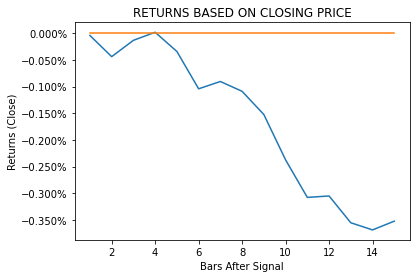

In [6]:
# CLOSING PRICE CALCULATIONS - Calculate the returns based upon the closing price of the signal bar.
# This assumes that we are watching the market and could possibly enter on the close of the signal bar.

# Calculate the returns for the signals.  Since I am using the zero element of the array I want to adjust the
# shift value to start at 1 and the name of the RetCL column to reflect the bar number in the analysis.
for i in range(0,15):
    df.loc[(df['SIGNAL'] == 1), 'RetCL' + str(i + 1)] = np.log(df['Close'].shift(-(i+1))/df['Close'])
    
# Find the mean and slope of the returns.  The mean is calcaluted over the full data population (versus a moving avearge)
ret_close = [0]*15
ret_slope_close = [0]*15
for i in range(0,15):
    ret_close[i] = np.nanmean(df['RetCL' + str(i + 1)])
    if i > 1:
        ret_slope_close[i] = (ret_close[i] - ret_close[0])/i

# Set up the plot x axis and zero reference for future plots
bar_count = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
zeros = np.zeros_like(ret_close)

# Plot the return results
plt.title("RETURNS BASED ON CLOSING PRICE")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count, ret_close)
plt.plot(bar_count, zeros)
plt.xlabel('Bars After Signal')
plt.ylabel('Returns (Close)')
print("")

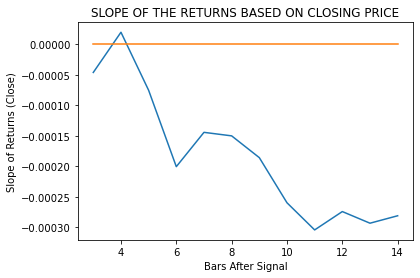

In [7]:
# Plot the slope of the returns over the 15 bar period.  Slope doesn't become interesing until the 3rd bar...

plt.title("SLOPE OF THE RETURNS BASED ON CLOSING PRICE")
plt.plot(bar_count[2:14], ret_slope_close[2:14])
plt.plot(bar_count[2:14], zeros[2:14])
plt.xlabel('Bars After Signal')
plt.ylabel('Slope of Returns (Close)')
print("")

Frequency of Signal under evaluation (Close):   1.79%
Frequency of Random Signal:   2.05%
Frequency of Random Signal:   1.67%
Frequency of Random Signal:   2.18%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   1.41%
Frequency of Random Signal:   1.54%
Frequency of Random Signal:   1.54%
Frequency of Random Signal:   1.92%
Frequency of Random Signal:   1.54%
Frequency of Random Signal:   1.15%
Frequency of Random Signal:   1.03%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   1.54%
Frequency of Random Signal:   2.05%
Frequency of Random Signal:   0.90%
Frequency of Random Signal:   1.41%
Frequency of Random Signal:   2.05%
Frequency of Random Signal:   1.79%
Frequency of Random Signal:   2.69%
Frequency of Random Signal:   1.28%



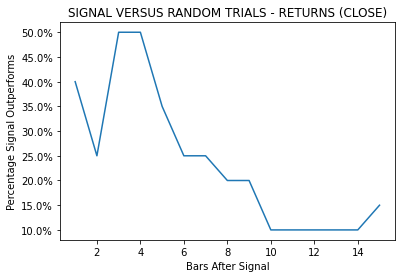

In [8]:
# RANDOM SIGNAL COMPARISON WITH SIGNAL BASED ON CLOSING PRICE
# Calculate returns based on a random signals.  Calculation is repeated 20 times
# and compared to the returns generated by the signal.  We are only going to 
# compare the returns and the slope.

# Set the number of trials
cl_trials = 20

# Set up signal versus random performance comparison array
svr_close = [0]*15
svr_slope_close = [0]*15

print("Frequency of Signal under evaluation (Close):  ", '{:2.2%}'.format(cl_freq))

# Do "x" iterations of random experiments
for i in range(0,cl_trials):
    # Generate a random number for each line/bar in the file
    df['CLX'] = 0
    for j, row in df.iterrows():
        df.at[j,'cl_x'] = random.random()
    df.loc[(df['cl_x'] <= cl_freq), 'CLX'] = 1
    
    # How many random signals were generated?
    r_cl_signals = df['CLX'].sum()  

    # Signal Frequency
    r_cl_freq = 0
    if bars != 0:
        r_cl_freq = r_cl_signals/bars
    
    print("Frequency of Random Signal:  ", '{:2.2%}'.format(r_cl_freq))
    
    # Clean the random returns column
    for j in range(0,15):
        df['RandomCL' + str(j + 1)] = np.nan
        
    # Calculate the random returns
    for j in range(0,15):
        df.loc[(df['CLX'] == 1), 'RandomCL' + str(j + 1)] = np.log(df['Close'].shift(-(j+1))/df['Close'])

    # Calculate the average returns per bar
    random_close = [0]*15
    random_slope_close = [0]*15
    for j in range(0,15):
        random_close[j] = np.nanmean(df['RandomCL' + str(j + 1)])
        if j > 1:
            random_slope_close[j] = (random_close[j] - random_close[0])/j

    # Compare the random trial returns to the trading signal returns
    for j in range(0,15):
        if ret_close[j] > random_close[j]:
            svr_close[j] += 1

    # Compare the random trial returns slope to the trading signal returns slope      
    for j in range(2,15):
        if ret_slope_close[j] > random_slope_close[j]:
            svr_slope_close[j] += 1

# Get the average number of times the signal was better than random
for i in range(0,15):
    svr_close[i] /= cl_trials
    svr_slope_close[i] /= cl_trials
        
plt.title("SIGNAL VERSUS RANDOM TRIALS - RETURNS (CLOSE)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count, svr_close)
plt.xlabel('Bars After Signal')
plt.ylabel('Percentage Signal Outperforms')
print("")

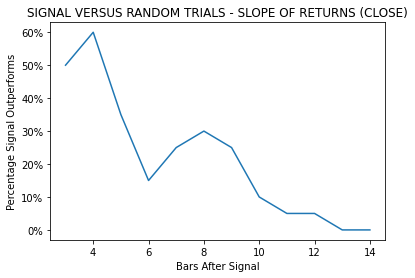

In [9]:
plt.title("SIGNAL VERSUS RANDOM TRIALS - SLOPE OF RETURNS (CLOSE)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count[2:14], svr_slope_close[2:14])
plt.xlabel('Bars After Signal')
plt.ylabel('Percentage Signal Outperforms')
print("")

In [10]:
# BUY STOP SCENARIO - Assume we wait until a buy stop order would have filled.
# Calculate returns on the high price of the signal bar - assuming the next bar takes out the high
# This is a buy stop scenario.

df.loc[(df['SIGNAL'] == 1) & (df['High'].shift(-1) > df['High']), 'BS_fill'] = 1

# How many fills for the buy stop?
bs_fill = df['BS_fill'].sum()

# Signal Frequency
bs_freq = 0
if bars != 0:
    bs_freq = bs_fill/bars

print("There were ", int(bs_fill), " trades")
print("Probability of Trading Signal:  ", '{:2.2%}'.format(bs_freq))

There were  9  trades
Probability of Trading Signal:   1.15%


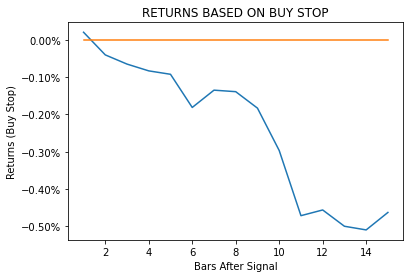

In [13]:
# Calculate "Buy Stop" returns
# Again, I want to use "+1" with the shift and column name.  The return is now based on the high price of 
# the signal bar
for i in range(0,15):
    df.loc[(df['BS_fill'] == 1), 'RetBS' + str(i + 1)] = np.log(df['Close'].shift(-(i+1))/df['High'])

ret_buystop = [0]*15
ret_slope_buystop = [0]*15
for i in range(0,15):
    ret_buystop[i] = np.nanmean(df['RetBS' + str(i + 1)])
    if i > 0:
        ret_slope_buystop[i] = (ret_buystop[i] - ret_buystop[0])/i

plt.title("RETURNS BASED ON BUY STOP")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count, ret_buystop)
plt.plot(bar_count, zeros)
plt.xlabel('Bars After Signal')
plt.ylabel('Returns (Buy Stop)')
print("")


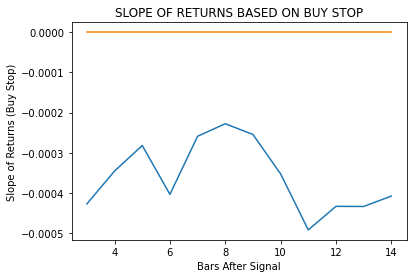

In [14]:
# Plot the slope of the returns over the 15 bar period

plt.title("SLOPE OF RETURNS BASED ON BUY STOP")
plt.plot(bar_count[2:14], ret_slope_buystop[2:14])
plt.plot(bar_count[2:14], zeros[2:14])
plt.xlabel('Bars After Signal')
plt.ylabel('Slope of Returns (Buy Stop)')
print("")

Frequency of Signal under evaluation (Buy Stop):   1.15%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   1.03%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   0.90%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   1.41%
Frequency of Random Signal:   0.90%
Frequency of Random Signal:   1.03%
Frequency of Random Signal:   1.67%
Frequency of Random Signal:   1.03%
Frequency of Random Signal:   0.51%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   0.77%
Frequency of Random Signal:   0.77%
Frequency of Random Signal:   0.51%
Frequency of Random Signal:   1.41%
Frequency of Random Signal:   1.28%
Frequency of Random Signal:   1.41%
Frequency of Random Signal:   1.79%
Frequency of Random Signal:   0.77%



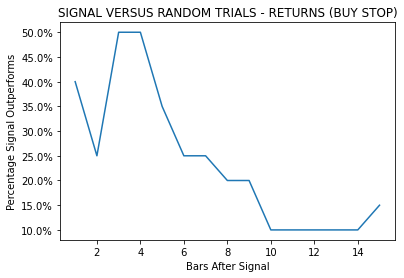

In [15]:
# RANDOM SIGNAL COMPARISON WITH SIGNAL BASED ON BUY STOP
# Calculate returns based on a random signals.  Calculation is repeated 20 times
# and compared to the returns generated by the signal. 

# Set the number of trials
bs_trials = 20

# Set up signal versus random performance comparison array
svr_buystop = [0]*15
svr_slope_buystop = [0]*15

print("Frequency of Signal under evaluation (Buy Stop):  ", '{:2.2%}'.format(bs_freq))

# Do "x" iterations of random experiments
for i in range(0,bs_trials):
    # Generate a random number for each line/bar in the file
    df['BSX'] = 0
    for j, row in df.iterrows():
        df.at[j,'bs_x'] = random.random()
    df.loc[(df['bs_x'] <= bs_freq), 'BSX'] = 1
    
    # How many random signals were generated?
    r_bs_signals = df['BSX'].sum()  

    # Signal Frequency
    r_bs_freq = 0
    if bars != 0:
        r_bs_freq = r_bs_signals/bars
    
    print("Frequency of Random Signal:  ", '{:2.2%}'.format(r_bs_freq))
    
    # Clean the random returns column
    for j in range(0,15):
        df['RandomBS' + str(j + 1)] = np.nan
        
    # Calculate the random returns
    for j in range(0,15):
        df.loc[(df['BSX'] == 1), 'RandomBS' + str(j + 1)] = np.log(df['Close'].shift(-(j+1))/df['Close'])

    # Calculate the average returns per bar
    random_buystop = [0]*15
    random_slope_buystop = [0]*15
    for j in range(0,15):
        random_buystop[j] = np.nanmean(df['RandomBS' + str(j + 1)])
        if j > 0:
            random_slope_buystop[j] = (random_buystop[j] - random_buystop[0])/j
    
    # Compare the random trial returns to the trading signal returns
    for j in range(0,15):
        if ret_buystop[j] > random_buystop[j]:
            svr_buystop[j] += 1

    # Compare the random trial returns slope to the trading signal returns slope      
    for j in range(2,15):
        if ret_slope_buystop[j] > random_slope_buystop[j]:
            svr_slope_buystop[j] += 1

# Get the average number of times the signal was better than random
for i in range(0,15):
    svr_buystop[i] /= bs_trials
    svr_slope_buystop[i] /= bs_trials

plt.title("SIGNAL VERSUS RANDOM TRIALS - RETURNS (BUY STOP)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count, svr_close)
plt.xlabel('Bars After Signal')
plt.ylabel('Percentage Signal Outperforms')
print("")

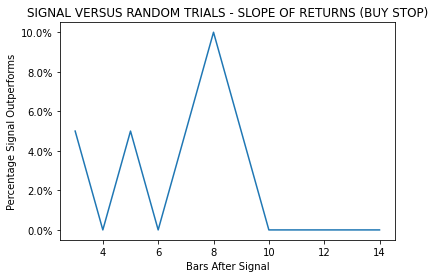

In [17]:
plt.title("SIGNAL VERSUS RANDOM TRIALS - SLOPE OF RETURNS (BUY STOP)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.plot(bar_count[2:14], svr_slope_buystop[2:14])
plt.xlabel('Bars After Signal')
plt.ylabel('Percentage Signal Outperforms')
print("")